# "Training an Agent to play Pong using Reinforcement Learning"

> Using a video image for state information, RL is used to teach an Agent to play Pong
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/PongPlayer_1.png
- categories: [Gaming,  Reinforcement_Learning,DQN,  OpenAI,Gym,TensorFlow,TF-Agents]
- show_tags: true

In [ ]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'RL/TF-Agents/blog_posts/TF-Agents-Pong'
# base_dir = ""

Mounted at /content/gdrive


In [ ]:
# hide
# use gif rotator once you have removed scores from display
# so that the agent plays on the left side (to mentally align with agent being
# on the left in diagrams)
# https://ezgif.com/rotate/ezgif-3-c95f05e1d62a.gif

## 1. Introduction

The Atari 2600 is a home video game console from Atari, Inc. It was released in 1977. It is credited with popularizing the use of microprocessor-based hardware and games stored on ROM cartridges instead of dedicated hardware with games physically built into the unit.

Atari games have become popular benchmarks for AI systems, particularly reinforcement learning. OpenAI Gym has a large number of these games available. Internally it uses the Stella Atari Emulator.

This blog post is about training a RL agent to play the Atari game Pong. Pong is a two-dimensional sports game that simulates table tennis. The player controls an in-game paddle by moving it vertically across the left or right side of the screen. Two players can compete against each other, each controlling their own paddle. Players use the paddles to hit a ball back and forth. For the Atari 2600 version of Pong, a computer player (controlled by the 2600) is the opposing player.


## 2. Solution Proposal

As mentioned, we will use Reinforcement Learning (RL) to solve this problem. The *agent* is the entity that will be trained enabling it to provide inputs to the *environment* in the form of *actions*. The environment will be the game board, the opposing player's paddle, as well as the agent's paddle. The *state* of the environment will be derived from one or more images from the visual simulator. There will be a single state variable in the form of a *cuboid*. The cuboid has 3 dimensions: One for the height of the image, one for the width, and a third for either the number of color channels or the number of black-and-white frames.

## 3. Implementation of the Solution
To implement the *environment* we use the OpenAI Gym tools. We will use the TF-Agents python library from Google to implement the *agent*. Because we have *discrete* actions we will use the Deep Q Network (DQN) network as a function approximator for the agent.

This implementation allows the agent to give simple categorical commands to its own paddle. The goal is to get the opponent to miss as many shots as possible - each miss scores a point for the agent.

The code will run on the Google Colab platform. To start with, we install the tf-agents python package.

In [ ]:
!pip install tf-agents

In [ ]:
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial
from gym.wrappers import TimeLimit

from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4
from tf_agents.utils import common
from tf_agents.metrics import tf_metrics
from tf_agents.metrics import py_metrics
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.eval.metric_utils import log_metrics
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.trajectories.trajectory import to_transition
from tf_agents.utils.common import function
from tf_agents.agents.dqn.dqn_agent import DqnAgent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.networks.q_network import QNetwork
from tf_agents.environments import tf_py_environment

import os
# from IPython.core.debugger import set_trace
import pickle

### 3.1 Environment
Let's setup a Pong environment and reset it to see what it looks like visually:

In [ ]:
# 
#repeatable runs:
np.random.seed(777)
tf.random.set_seed(777)

In [ ]:
#load the atari environment
max_episode_frames = 108_000
env_name = "PongNoFrameskip-v4"
env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames/4,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

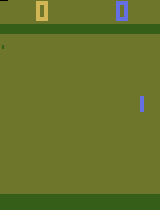

In [ ]:
env.reset()
PIL.Image.fromarray(env.render())

Next we will setup two environments - one for training and the other for evaluation. Then we wrap the two environments for TF-Agents:

In [ ]:
train_py_env = suite_atari.load( #for training
    env_name,
    max_episode_steps=max_episode_frames/4,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])
eval_py_env = suite_atari.load( #for evaluation
    env_name,
    max_episode_steps=max_episode_frames/4,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [ ]:
# hide
# train_py_env.observation_spec()

In [ ]:
# hide
# train_py_env.action_spec()

### 3.2 Agent

#### 3.2.1 Network (DQN)
The QNetwork makes use of a preprocessing layer that divides the pixel values by 255. This division assists the neural network by normalizing the pixel values to between 0 and 1.

The parameter `conv_layer_params` defines the CNN which forms the main part of the function approximation mechanism. It consists of 3 layers. Each layer is represented by a length-three tuple indicating (filters, kernel_size, stride). For example, the first layer has 32 filters, a kernel of 8x8 and a stride of 4.

The `fc_layer_params` parameter defines the final fully-connected layer of the CNN and consists of 512 neurons.

In [ ]:
#
# Q-Network, DQN
preprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32)/255.)
# list of convolution layers parameters: Each item is a length-three tuple 
# indicating (filters, kernel_size, stride):
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]
q_net = QNetwork(
    input_tensor_spec=    train_env.observation_spec(),
    action_spec=          train_env.action_spec(),
    preprocessing_layers= preprocessing_layer,
    conv_layer_params=    conv_layer_params,
    fc_layer_params=      fc_layer_params)

#### 3.2.2 Optimizer
Next, we define the optimizer. We will use the AdamOptimizer. RMSPropOptimizer is another popular option.

In [ ]:
LEARNING_RATE = 0.25e-3
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=LEARNING_RATE)

#### 3.2.3 Agent
We define a epsilon-greedy function starting at an `initial_learning_rate` of `1.0` and ending at `end_learning_rate` of `0.01`:

In [ ]:
COLLECT_STEPS_PER_ITERATION = 4 
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, 
    decay_steps=150_000//COLLECT_STEPS_PER_ITERATION, 
    end_learning_rate=0.01)

Now we instantiate and initialize the agent:

In [ ]:
global_step = tf.compat.v1.train.get_or_create_global_step(); print(global_step) #.
TARGET_COLLECT_STEPS_PER_ITERATION = 2000
agent = DqnAgent(
    time_step_spec=       train_env.time_step_spec(), 
    action_spec=          train_env.action_spec(),
    q_network=            q_net,
    optimizer=            optimizer,
    target_update_period= TARGET_COLLECT_STEPS_PER_ITERATION, 
    td_errors_loss_fn=    common.element_wise_squared_loss, 
    gamma=                0.99, 
    train_step_counter=   global_step, #.
    epsilon_greedy=       lambda: epsilon_fn(global_step)) #.
agent.initialize()

<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=381000>


#### 3.2.4 Metrics for Evaluation
We need to measure the effectiveness of a model trained with reinforcement learning.  The loss function of the internal Q-network is not a good measure because it measures how close the Q-network was fit to the collected data and does not indicate how effective the DQN is in maximizing rewards. The method we use here is the average reward received over several episodes. We also make use of built-in metrics:

In [ ]:
train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

In [ ]:
# hide
train_metrics[2].result().numpy()

0.0

In [ ]:
# find average return when using eval env
def compute_avg_return(env, pol, num_episodes=10):
  print(f"... computing avg return with num_episodes={num_episodes}")
  total_return = 0.0
  for _ in range(num_episodes):
    tstep = env.reset()
    episode_return = 0.0
    while not tstep.is_last():
      pstep = pol.action(tstep)
      tstep = env.step(pstep.action)
      episode_return += tstep.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

#### 3.2.5 Data Collection

##### 3.2.5.1 Replay buffer
The DQN works by training a neural network to predict the Q-values for every state of the environment. Because the DQN does not have pre-existing training data this data has to be accumulated as the agent and environment evolves through steps. The accumulated data is stored in the replay buffer. The replay buffer is a First-In-First-Out (FIFO) buffer. Only the most recent episodes are stored, older episode data rolls off the queue as the queue accumulates new data.

In [ ]:
REPLAY_BUFFER_MAX_LENGTH = 100_000 #.
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=  agent.collect_data_spec,
    batch_size= train_env.batch_size,
    max_length= REPLAY_BUFFER_MAX_LENGTH)
replay_buffer_observer = replay_buffer.add_batch

Training cannot begin on an empty `replay buffer`. Next, we fill the `replay_buffer` with random data, but first we setup a quick object to show progress:

In [ ]:
class Progress: #class to show progress
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

Now we run the `init-driver` to collect an initial `INITIAL_COLLECT_STEPS` to prime the `replay_buffer` with some random data. Note that we will only do this when we start with a new global training session. If we resume an existing training session, this cell should be commented out:

In [ ]:
# 
# INITIAL_COLLECT_STEPS = 20_000
# initial_collect_policy = RandomTFPolicy(train_env.time_step_spec(),
#                                         train_env.action_spec())
# init_driver = DynamicStepDriver(
#     env=       train_env, 
#     policy=    initial_collect_policy,
#     observers= [replay_buffer.add_batch, Progress(20_000)],
#     num_steps= INITIAL_COLLECT_STEPS
#     )
# final_time_step, final_policy_state = init_driver.run()

##### 3.2.5.2 Create the Dataset
We also create an associated dataset for the `replay_buffer`:

In [ ]:
BATCH_SIZE = 64
dataset = replay_buffer.as_dataset(
    sample_batch_size=  BATCH_SIZE,
    num_steps=          2,
    num_parallel_calls= 3).prefetch(3)

##### 3.2.5.3 Collect Policy
Next we create the `collect_driver` which collects additional data for the `replay_buffer` every `COLLECT_STEPS_PER_ITERATION`.

In [ ]:
collect_driver = DynamicStepDriver(
    env=       train_env, 
    policy=    agent.collect_policy,
    observers= [replay_buffer_observer] + train_metrics,
    num_steps= COLLECT_STEPS_PER_ITERATION) 

#### 3.2.6 Mechanism to continue training over multiple sessions
Running on Google Colab, as we are, we don't have enough time to ensure sufficient training. Colab will terminate our process if we let it run for too long. We need a mechanism to resume training from a previous checkpoint so that we can pickup and continue with training. This way we can splice together many small training sessions without losing previous progress. First, we need to setup a Checkpointer and PolicySaver.

##### 3.2.6.1 Setup Checkpointer and PolicySaver
In addition to setting up the Checkpointer and PolicySaver we will also setup two pickle files: One to store accumulated returns and another to store accumulated losses:

In [ ]:
# 
# Setup Checkpointer and PolicySaver
model = 'policy1'
from pathlib import Path
#   Checkpointer
checkpoint_dir = Path(f'{base_dir}/{model}/checkpoint'); #print(checkpoint_dir)
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step #.
)
#   PolicySaver
from tf_agents.policies import policy_saver
policy_dir = Path(f'{base_dir}/{model}/policy'); #print(policy_dir)
policy_saver = policy_saver.PolicySaver(policy=agent.policy)
#   Returns
returns_pkl_file = Path(f'{base_dir}/{model}/returns.pkl'); #print(returns_pkl_file)
#   Losses
losses_pkl_file = Path(f'{base_dir}/{model}/losses.pkl'); #print(losses_pkl_file);

##### 3.2.6.2 Restore checkpoint
For this to work, the whole set of objects will be recreated the same way as when the checkpoint was created.

In [ ]:
# hide
# seems like i have to pick a checkpoint to restore, like this (sedi) ?????????
# tf_agent.train_step_counter.assign(5000)

In [ ]:
# 
# Restore checkpoint
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()
tf.print(global_step)

381000


##### 3.2.6.3 Restore policy
The policy can be loaded without having any knowledge of what agent or network was used to create it. This makes deployment of the policy much easier.

In [ ]:
# 
# Restore policy
# saved_policy = tf.compat.v2.saved_model.load(str(policy_dir))

##### 3.2.6.4 Restore returns

In [ ]:
# 
# Restore returns
try:
  with open(returns_pkl_file, "rb") as fp: 
    returns = pickle.load(fp); print(returns)
except FileNotFoundError:
  print("... file does not exist yet")
# Restore losses
try:
  with open(losses_pkl_file, "rb") as fp: 
    losses = pickle.load(fp); print(losses)
except FileNotFoundError:
  print("... file does not exist yet")

[-18.25, -19.9, -20.3, -20.6, -20.5, -18.7, -18.0, -16.5, -16.8, -16.3, -15.5, -14.1, -12.1, -14.8, -12.7, -11.2, -8.5, -7.1, -3.0, -0.5, 2.0, 6.4, 10.6, 9.5, 6.5, 8.0, 7.5, 6.9, 14.9, 14.8, 12.2, 14.6, 17.2, 17.5, 16.6, 16.6, 18.8, 18.0, 18.7, 18.6, 19.1, 19.25, 19.3, 18.5, 20.0, 20.2, 20.1, 19.8, 18.1, 19.6, 19.7, 20.4, 20.1, 20.5, 20.4, 20.2, 20.2, 19.9, 18.5, 19.9, 19.9, 19.9, 20.7, 20.6, 20.5, 19.6, 17.9, 20.0, 19.8, 20.2, 20.4, 19.7, 19.6, 19.2, 20.7, 21.0, 21.0]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### 3.2.7 Train the agent
We are finally ready to train the agent.

##### 3.2.7.1 Train

In [ ]:
# 
# initialize returns and losses
try:
  returns
except NameError:
  returns = []
  print("... initialized returns global variable")
try:
  losses
except NameError:
  losses = []
  print("... initialized losses global variable")

In [ ]:
# 
# convert the main functions to TF functions
collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [97]:
def train_agent(n_iterations, loss_interval, log_interval, eval_interval, n_eval_episodes):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
    iterator = iter(dataset)
    #eval agent's policy once before NEW training:
    if len(losses) == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, n_eval_episodes) #comment out to save time with short trial runs
        # avg_return = train_metrics[2].result().numpy() #comment out to save time with short trial runs
        returns.append(avg_return)
    for i in range(n_iterations):
        #collect and save to replay_buffer:
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        
        #sample batch from replay_buffer and update agent's network:
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories).loss
        # losses.append(train_loss.numpy())

        step = agent.train_step_counter.numpy(); #print(f'i={i}, step={step}: loss={train_loss}')
        if step % loss_interval == 0: losses.append(train_loss.numpy())
        if step % log_interval == 0: print(f'i={i+1}, step={step}: loss={train_loss:.5f}')
        if step % eval_interval == 0: 
            avg_return = compute_avg_return(eval_env, agent.policy, n_eval_episodes)
            # avg_return = train_metrics[2].result().numpy()
            print(f'step={step}: Average Return={avg_return}')
            returns.append(avg_return)
    print('returns:', returns)
    #persist:
    with open(returns_pkl_file, "wb") as fp: pickle.dump(returns, fp)
    with open(losses_pkl_file, "wb") as fp: pickle.dump(losses, fp)
    train_checkpointer.save(global_step)
    policy_saver.save(str(policy_dir))

In [105]:
N_ITERATIONS = 9_000 #20_000 #per training session
LOSS_INTERVAL = 1
LOG_INTERVAL = 500
EVAL_INTERVAL = 5_000
NUM_EVAL_EPISODES = 5
train_agent(
    n_iterations=N_ITERATIONS, 
    loss_interval=LOSS_INTERVAL, 
    log_interval=LOG_INTERVAL, 
    eval_interval=EVAL_INTERVAL, 
    n_eval_episodes=NUM_EVAL_EPISODES);

i=500, step=401500: loss=0.00028
i=1000, step=402000: loss=0.00080
i=1500, step=402500: loss=0.00114
i=2000, step=403000: loss=0.00028
i=2500, step=403500: loss=0.00026
i=3000, step=404000: loss=0.00050
i=3500, step=404500: loss=0.00016
i=4000, step=405000: loss=0.00030
... computing avg return with num_episodes=5
step=405000: Average Return=21.0
i=4500, step=405500: loss=0.00066
i=5000, step=406000: loss=0.00039
i=5500, step=406500: loss=0.00017
i=6000, step=407000: loss=0.00039
i=6500, step=407500: loss=0.00107
i=7000, step=408000: loss=0.00110
i=7500, step=408500: loss=0.00026
i=8000, step=409000: loss=0.00197
i=8500, step=409500: loss=0.00110
i=9000, step=410000: loss=0.00058
... computing avg return with num_episodes=5
step=410000: Average Return=21.0
returns: [-18.25, -19.9, -20.3, -20.6, -20.5, -18.7, -18.0, -16.5, -16.8, -16.3, -15.5, -14.1, -12.1, -14.8, -12.7, -11.2, -8.5, -7.1, -3.0, -0.5, 2.0, 6.4, 10.6, 9.5, 6.5, 8.0, 7.5, 6.9, 14.9, 14.8, 12.2, 14.6, 17.2, 17.5, 16.6, 16.

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/RL/TF-Agents/blog_posts/TF-Agents-Pong/policy1/policy/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/RL/TF-Agents/blog_posts/TF-Agents-Pong/policy1/policy/assets


In [106]:
print(global_step)

<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=410000>


##### 3.2.7.2 Visualize training results

In [107]:
# hide
# https://stackoverflow.com/questions/64799299/use-tensorboard-to-visualize-graph-from-tf-agents

In [108]:
evals = range(0, global_step.numpy()+1, EVAL_INTERVAL); print(f"evals: {evals}")
# list(evals)

evals: range(0, 410001, 5000)


evals: range(0, 410001, 5000), 
list(evals): [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000], 
returns: [-18.25, -19.9, -20.3, -20.6, -20.5, -18.7, -18.0, -16.5, -16.8, -16.3, -15.5, -14.1, -12.1, -14.8, -12.7, -11.2, -8.5, -7.1, -3.0, -0.5, 2.0, 6.4, 10.6, 9.5, 6.5, 8.0, 7.5, 6.9, 14.9, 14.8, 12.2, 14.6, 17.2, 17.5, 16.6, 16.6, 18.8, 18.0, 18.7, 18.6, 19.1, 19.25, 19.3, 18.5, 20.0, 20.2, 20.1, 19.8, 18.1

Text(0, 0.5, 'Average Return')

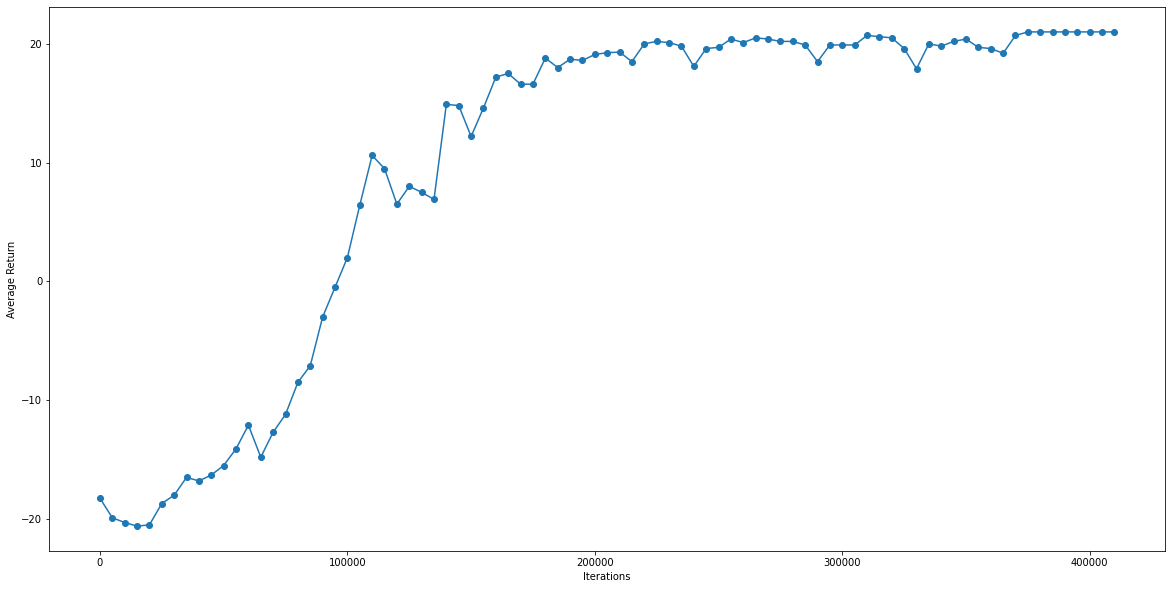

In [109]:
# print(eval_interval)
# evals = range(0, num_iterations+1, eval_interval); print(f"evals: {evals}, \nlist(evals): {list(evals)}, \nreturns: {returns}")
evals = range(0, global_step.numpy()+1, EVAL_INTERVAL); print(f"evals: {evals}, \nlist(evals): {list(evals)}, \nreturns: {returns}")
plt.figure(figsize=(20,10))
plt.plot(list(evals), returns)
plt.scatter(list(evals), returns)
plt.xlabel('Iterations')
plt.ylabel('Average Return')
# plt.ylim(top=50)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0, 0.5, 'Loss')

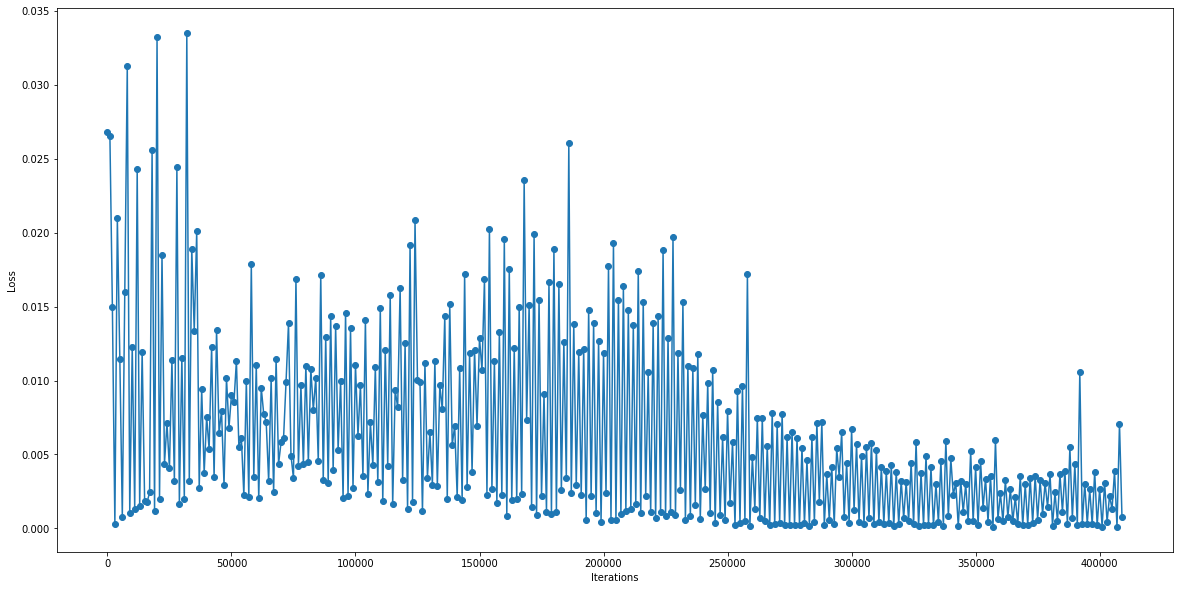

In [110]:
# evals = range(0, global_step.numpy()+1, EVAL_INTERVAL); print(f"evals: {evals}, \nlist(evals): {list(evals)}, \nreturns: {returns}")
# plt.plot(list(evals), returns)
# plt.scatter(list(evals), returns)

every = 1000*LOSS_INTERVAL
# its = range(0, global_step.numpy()); print(f"its: {its}, \nlist(its): {list(its)}, \nlosses: {losses}")
its = range(0, global_step.numpy(), every); print(f"its: {its}, \nlist(its): {list(its)}, \nlosses: {losses}")
plt.figure(figsize=(20,10))
# plt.plot(losses)
plt.plot(its, losses[::every])
plt.scatter(its, losses[::every])
# plt.plot([e.numpy() for e in losses])
# plt.scatter(list(its), losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')

### 3.3 Evaluation and Visualization

#### 3.3.1 Animated GIF

In [111]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [114]:
# env = train_env
env = eval_env
frames = []
def save_frames(trajectory):
    global frames
    frames.append(env.pyenv.envs[0].render(mode="rgb_array"))

prev_lives = env.pyenv.envs[0].ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        env.reset()
        env.pyenv.envs[0].step(1)
        prev_lives = lives

# access the deployment policy
watch_driver = DynamicStepDriver(
    env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, Progress(1000)],
    num_steps=1000)
    # num_steps=2000) #.

final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

1000/1000

In [115]:
# save the animated gif
# image_path = os.path.join("PongPlayer_train.gif")
image_path = os.path.join("PongPlayer_eval.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:500]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=60,
                    #  duration=120, #.
                     loop=0)

In [116]:
ls

gdrive/  PongPlayer_eval.gif  sample_data/


In [117]:
pwd

'/content'

#### 3.3.2 Video

In [118]:
# 
# Set up a virtual display for rendering OpenAI gym environments.
!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'gym==0.10.11'
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay

import base64
import imageio
import IPython
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 10 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 784 kB in 1s (1,110 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected pa

In [119]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      tstep = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not tstep.is_last():
        pstep = policy.action(tstep)
        tstep = eval_env.step(pstep.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [120]:
create_policy_eval_video(agent.policy, "trained-agent")

In [121]:
ls

gdrive/  PongPlayer_eval.gif  sample_data/  trained-agent.mp4


In [122]:
# hide
# # INITIAL_COLLECT_STEPS = 20_000
# INITIAL_COLLECT_STEPS = 1_000 #.
# # fill the replay buffer with random data
# initial_collect_policy = RandomTFPolicy(train_env.time_step_spec(),
#                                         train_env.action_spec())
# init_driver = DynamicStepDriver(
#     env=       train_env, 
#     policy=    initial_collect_policy,
#     observers= [replay_buffer.add_batch, ShowProgress(20_000)],
#     num_steps= INITIAL_COLLECT_STEPS
#     )
# final_time_step, final_policy_state = init_driver.run()

In [123]:
# hide
# create_policy_eval_video(initial_collect_policy, "random-agent")